In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')

import data_processing as proc
import utils
import performance as perf
import input_feature_engineering as ife
import target_feature_engineering as tfe
import check_features as check_feat

In [4]:
from sqlalchemy import create_engine, text

In [5]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])

k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']
k200_df=k200_df.sort_index(0)

<ipython-input-5-4c682375b2e8>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  k200_df=k200_df.sort_index(0)


In [ ]:
period1='2023-09-27'
period2='2023-09-27'

In [6]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

query_COM=f"select * from COM_table_Bak where (Dates>='{period1}' and Dates<='{period2}')"
data_COM=pd.read_sql(query_COM, conn)

In [7]:
sector=data_COM.set_index(['Dates', 'Symbol'])['FG_IndustryGroup_Idx'].copy()

In [8]:
prob_file= '../data/output/prob_out/multilayer_factor_rolling_v1.0_2023-09-27.csv'
mlq_w=pd.read_csv(prob_file, index_col=0)
mlq_w

,A000080,A000100,A000120,A000150,A000210,A000240,A000270,A000660,A000670,A000720,...,A329180,A336260,A352820,A361610,A373220,A375500,A377300,A381970,A383220,A402340
Dates,,,,,,,,,,,,,,,,,,,,,
2023-08-25,0.004694,0.002115,0.004907,0.006516,0.007797,0.007367,0.003361,0.000500,0.002966,0.002447,...,0.001854,0.003340,0.002034,0.001737,0.001025,0.006156,0.002653,0.004109,0.005712,0.001281
2023-09-01,0.004694,0.002115,0.004907,0.006516,0.007797,0.007367,0.003361,0.000500,0.002966,0.002447,...,0.001854,0.003340,0.002034,0.001737,0.001025,0.006156,0.002653,0.004109,0.005712,0.001281
2023-09-08,0.004694,0.002115,0.004907,0.006516,0.007797,0.007367,0.003361,0.000500,0.002966,0.002447,...,0.001854,0.003340,0.002034,0.001737,0.001025,0.006156,0.002653,0.004109,0.005712,0.001281
2023-09-15,0.004694,0.002115,0.004907,0.006516,0.007797,0.007367,0.003361,0.000500,0.002966,0.002447,...,0.001854,0.003340,0.002034,0.001737,0.001025,0.006156,0.002653,0.004109,0.005712,0.001281
2023-09-22,0.004694,0.002115,0.004907,0.006516,0.007797,0.007367,0.003361,0.000500,0.002966,0.002447,...,0.001854,0.003340,0.002034,0.001737,0.001025,0.006156,0.002653,0.004109,0.005712,0.001281
2023-09-27,0.005837,0.002061,0.006252,0.004413,0.008440,0.007133,0.006182,0.000109,0.001912,0.002469,...,0.002019,0.003693,0.001161,0.001771,0.000317,0.008145,0.002203,0.005704,0.006909,0.000451


In [9]:
mlq_w.index = pd.to_datetime(mlq_w.index)

In [10]:
# data_path='./data/output/weight/'
# mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)
# mlq_w=mlq_w[['code', 'weights']].pivot_table(index='dates', columns='code')
# mlq_w.columns=mlq_w.columns.get_level_values(1)

In [11]:
price=pd.read_parquet('../data/price_data_2023-09-27.parquet')
price.columns=price.columns.get_level_values(1)

In [12]:
factors=pd.read_parquet('../data/k200_weekly_factor_data_2023-09-27v.1.parquet')
indicies=pd.read_parquet('../data/krx_idx_2023-09-27.parquet')

In [16]:
# period1='2010-01-01'
# period2='2023-08-25'

In [17]:
# query_SSC=f"select * from SSC_table_Bak where Dates>='{period1}' and Dates<='{period2}'"
# data_SSC=pd.read_sql(query_SSC, conn)
# query_IFRS=f"select * from IFRS_Table where Dates>='{period1}' and Dates<='{period2}'"
# data_IFRS=pd.read_sql(query_IFRS, conn)

In [18]:
# f_size=['size']
# f_dividend=['dividend']
# f_prcMom=['priceMomentum']
# f_tradVol=['trading']
# f_invSent=['investSentiment']
# f_earninYield=['epsF_p', 'earningsOtmv']
# f_prcRev=['52H/p_Mom', '52L/p_Mom']
# f_stability=['dtoequity', 'deltaDtoEquityYoY']
# f_priceStdev=['stStevOLtStdev', 'Vol_20D', 'Vol_120D']
# f_quality=['roeF_proxy', 'roeT_proxy', 'roeQ']
# f_adjMom=['dEpsOp', 'rAdjdEpsOp']
# f_mom=['roeFTMom', 'epsFMom', 'salseFMom', 'roeFchg_proxy', 'slsAdjEarningsYOY', 'sprsEarningsOearningsAvgPstdev']
# f_growth=['epsFTMom', 'earningsFTMom', 'earningsYOY', 'salesYOY', 'cashFlowYOY']
# f_value=['salesOtmv', 'cashFlowOtmv', 'equityOtmv', 'bpsF_p', 'bpsT_p', 'spsF_p', 'spsT_p', 'cfpsF_p']

factor_ls=[f_size, f_dividend, f_prcMom, f_tradVol, f_invSent, f_earninYield, f_prcRev, f_stability, f_priceStdev,
           f_quality, f_adjMom, f_mom, f_growth, f_value]
factor_name_ls=['size', 'dividend', 'prcMom', 'tradVol', 'invSent', 'earninYield', 'prcRev', 'stability',
                'priceStdev', 'quality', 'adjMom', 'mom', 'growth', 'value']

NameError: name 'f_size' is not defined

In [ ]:
# f_value=['SE_TQ', 'MktCap_Comm_Pref']
# f_mom=['AdjPrc'] # ssc
# f_quality=['GP_TQ', 'Assets_TQ']
# f_div=['DPS_Adj']
# f_size=['MktCap_Comm_Pref'] # ssc
# f_vol=['BETA_1Y', 'VOL_1Y'] # ssc
# factor_ls=[f_selected]

In [19]:
ifrs_col=['Dates', 'Symbol', 'SE_TQ', 'Assets_TQ']
ifrs_col2=['Dates', 'Symbol', 'GP_TQ', 'DPS_Adj']

ssc_col=['Dates', 'Symbol', 'MktCap_Comm_Pref', 'AdjPrc']
ssc_col2=['Dates', 'Symbol', 'BETA_1Y', 'VOL_1Y']

In [20]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

query_IFRS = f"SELECT {', '.join(ifrs_col)} FROM IFRS_Table where Dates>='{period1}' and Dates<='{period2}'"
data_IFRS=pd.read_sql(query_IFRS, conn)

query_IFRS2 = f"SELECT {', '.join(ifrs_col2)} FROM IFRS_Table_copy where Dates>='{period1}' and Dates<='{period2}'"
data_IFRS2=pd.read_sql(query_IFRS2, conn)

query_SSC = f"SELECT {', '.join(ssc_col)} FROM SSC_table_Bak where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

query_SSC2 = f"SELECT {', '.join(ssc_col2)} FROM SSC_table_Bak_copy where Dates>='{period1}' and Dates<='{period2}'"
data_SSC2=pd.read_sql(query_SSC2, conn)

In [21]:
data_IFRS.set_index(['Dates', 'Symbol'], inplace=True)
data_IFRS2.set_index(['Dates', 'Symbol'], inplace=True)
data_SSC.set_index(['Dates', 'Symbol'], inplace=True)
data_SSC2.set_index(['Dates', 'Symbol'], inplace=True)

In [22]:
raw_data=pd.concat([data_IFRS, data_IFRS2, data_SSC, data_SSC2], axis=1).dropna(how='all')

In [27]:
# value
f_value=(raw_data['SE_TQ']/raw_data['MktCap_Comm_Pref']).dropna()

# momentum
f_mom=(raw_data['AdjPrc'].unstack().pct_change(252)-raw_data['AdjPrc'].unstack().pct_change(20)).stack()

# quality
f_quality=(raw_data['GP_TQ'].astype(float)/raw_data['Assets_TQ']).dropna()

# div
f_div=(raw_data['DPS_Adj'].astype(float)/raw_data['AdjPrc']).dropna()

f_size=raw_data['MktCap_Comm_Pref']

f_vol=raw_data[['BETA_1Y', 'VOL_1Y']].astype(float).mean(1).dropna()

In [67]:
factor_ls=[f_value, f_mom, f_quality, f_div, f_size, f_vol]
factor_name_ls=['value', 'momentum', 'quality', 'dividend', 'size', 'volatility']

In [68]:
factors=pd.concat([f_value, f_mom, f_quality, f_div, f_size, f_vol], axis=1)
factors.columns=factor_name_ls

factor_dates=factors.index.get_level_values(0).unique()
factor_dates=pd.to_datetime(factor_dates)

In [69]:
factors

0   1         2         3  MktCap_Comm_Pref  \
Dates      Symbol                                                           
2023-09-27 A000020  1441.533201 NaN  0.095856  0.018367          273728.0   
           A000040   331.287955 NaN  0.014160       NaN           82006.0   
           A000050  3192.703920 NaN  0.016333  0.014741          232481.0   
           A000070  4176.438281 NaN  0.032322  0.050143          613597.0   
           A000080   827.095630 NaN  0.085097  0.050291         1341840.0   
...                         ...  ..       ...       ...               ...   
           A092440          NaN NaN  0.018136  0.047319           92564.0   
           A103160          NaN NaN  0.121734       NaN               NaN   
           A192520          NaN NaN  0.004936       NaN               NaN   
           A192530          NaN NaN  0.007085       NaN               NaN   
           A030790          NaN NaN       NaN       NaN           19208.0   

                           4  
Dates      Symbol             
2023-09-27 A000020  0.499815  
           A000040  0.616065  
           A000050  0.319285  
           A000070  0.452570  
           A000080  0.491760  
...                      ...  
           A092440  0.326790  
           A103160       NaN  
           A192520       NaN  
           A192530       NaN  
           A030790  0.000000  

[837 rows x 6 columns]

In [71]:
factors.index.get_level_values(0).unique()

DatetimeIndex(['2023-09-27'], dtype='datetime64[ns]', name='Dates', freq=None)

In [73]:
idxw=k200_df['idx_weight'].unstack()

In [82]:
num_stocks=70
bm_name='코스피 200'
start_date='2023-09-27'
end_date='2023-09-27'

In [83]:
temp_factor_dates=factor_dates[(factor_dates>=start_date) & (factor_dates<=end_date)]
temp_factor_dates

DatetimeIndex(['2023-09-27'], dtype='datetime64[ns]', name='Dates', freq=None)

In [84]:
rebal_dates=proc.find_entire_rebalancing_dates(temp_factor_dates)
rebal_dates=temp_factor_dates

lack of the beginning part of data  2023-08-31 00:00:00 2023-09-27 00:00:00


In [85]:
def factor_performance(factor_slice, num_stocks, bm_name, price, indicies):
    factor_slice=factor_slice.unstack()
    if isinstance(factor_slice.columns, pd.MultiIndex):
        factor_slice.columns=factor_slice.columns.get_level_values(1)
        
    factor_slice=factor_slice.rank(1, ascending=False)
    factor_slice[factor_slice<=num_stocks]=1/num_stocks
    factor_slice[factor_slice>num_stocks]=0.0
    factor_slice=factor_slice.fillna(0)
    
    port_df=pd.DataFrame(None, index=price.index, columns=price.columns)
    port_df.loc[factor_slice.index, factor_slice.columns]=factor_slice
    port_df=port_df.fillna(method='ffill').dropna(how='all', axis=0)
    daily_ret=(port_df*price.pct_change().loc[port_df.index, :]).sum(1)
    bm_ret=indicies[bm_name].pct_change().loc[daily_ret.index]
    excess_ret=((1+daily_ret-bm_ret).cumprod()-1)

    return excess_ret

def factor_scaler(factor_slice, idx_weight):
    # 1. find ranking for each factor in the universe
    # 2. then zscore
    # 3. multiply zscore * weight of stocks in strategy

    unstacked=factor_slice.unstack()
    if isinstance(unstacked.columns, pd.MultiIndex):
        unstacked.columns=unstacked.columns.get_level_values(1)
        
    unstacked=unstacked.replace([np.inf, -np.inf], None)
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(unstacked.T)
    scaled_df=pd.DataFrame(scaled, columns=unstacked.index, index= unstacked.columns)
    scaled_df=scaled_df.T
    return (scaled_df*idx_weight).dropna(how='all').sum(1)


In [86]:
# mlq_w.index=factor_slice.index.get_level_values(0).unique()[:-1]

In [176]:
factors

value  momentum   quality  dividend       size  \
Dates      Symbol                                                          
2023-09-27 A000020  1441.533201       NaN  0.095856  0.018367   273728.0   
           A000040   331.287955       NaN  0.014160       NaN    82006.0   
           A000050  3192.703920       NaN  0.016333  0.014741   232481.0   
           A000070  4176.438281       NaN  0.032322  0.050143   613597.0   
           A000080   827.095630       NaN  0.085097  0.050291  1341840.0   
...                         ...       ...       ...       ...        ...   
           A092440          NaN       NaN  0.018136  0.047319    92564.0   
           A103160          NaN       NaN  0.121734       NaN        NaN   
           A192520          NaN       NaN  0.004936       NaN        NaN   
           A192530          NaN       NaN  0.007085       NaN        NaN   
           A030790          NaN       NaN       NaN       NaN    19208.0   

                    volatility  
Dates      Symbol               
2023-09-27 A000020    0.499815  
           A000040    0.616065  
           A000050    0.319285  
           A000070    0.452570  
           A000080    0.491760  
...                        ...  
           A092440    0.326790  
           A103160         NaN  
           A192520         NaN  
           A192530         NaN  
           A030790    0.000000  

[837 rows x 6 columns]

In [163]:
port_w=mlq_w # idxw/100, mlq_w

factor_score_ls=[]
factor_performance_ls=[]
for f in factor_name_ls:
    if isinstance(f, list):
        sub_factor_perf_ls=[]
        sub_factor_score_ls=[]
        for sub_f in range(len(f)):
            factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f[sub_f]]
            sub_factor_perf_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
            sub_factor_score_ls.append(factor_scaler(factor_slice, port_w))            
        factor_performance_ls.append(pd.concat(sub_factor_perf_ls, axis=1).mean(1))
        factor_score_ls.append(pd.concat(sub_factor_score_ls, axis=1).mean(1))
        
    else:
        factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f]
        factor_performance_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
        factor_score_ls.append(factor_scaler(factor_slice, port_w))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [149]:
rebal_dates

DatetimeIndex(['2023-09-27'], dtype='datetime64[ns]', name='Dates', freq=None)

In [150]:
port_w.loc['2023-09-27']

Symbol
A000030       NaN
A000050       NaN
A000060       NaN
A000070       NaN
A000080    0.0005
            ...  
A377300    0.0026
A381970    0.0001
A383220    0.0017
A383800       NaN
A402340    0.0039
Name: 2023-09-27 00:00:00, Length: 292, dtype: float64

In [164]:
port_w=idxw/100 # idxw/100, mlq_w

factor_score_bm_ls=[]
factor_performance_bm_ls=[]
for f in factor_name_ls:
    if isinstance(f, list):
        sub_factor_perf_bm_ls=[]
        sub_factor_score_bm_ls=[]
        for sub_f in range(len(f)):
            factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f[sub_f]]
            sub_factor_perf_bm_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
            sub_factor_score_bm_ls.append(factor_scaler(factor_slice, port_w))            
        factor_performance_bm_ls.append(pd.concat(sub_factor_perf_ls, axis=1).mean(1))
        factor_score_bm_ls.append(pd.concat(sub_factor_score_ls, axis=1).mean(1))
        
    else:
        factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f]
        factor_performance_bm_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
        factor_score_bm_ls.append(factor_scaler(factor_slice, port_w))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [165]:
factor_res=pd.concat(factor_performance_ls, axis=1)
factor_res.columns=factor_name_ls

factor_score_res=pd.concat(factor_score_ls, axis=1)
factor_score_res.columns=factor_name_ls

In [166]:
factor_res_bm=pd.concat(factor_performance_bm_ls, axis=1)
factor_res_bm.columns=factor_name_ls

factor_score_bm_res=pd.concat(factor_score_bm_ls, axis=1)
factor_score_bm_res.columns=factor_name_ls

In [167]:
factor_score_res

,value,momentum,quality,dividend,size,volatility
Dates,,,,,,
2023-09-27,0.079854,NaN,0.068771,0.474206,0.195869,-0.061117


In [168]:
factor_score_bm_res

,value,momentum,quality,dividend,size,volatility
Dates,,,,,,
2023-09-27,-0.460679,NaN,-0.110433,-0.197997,8.868061,0.316356


In [169]:
factor_perf_diff=factor_res - factor_res_bm
factor_score_diff=factor_score_res - factor_score_bm_res

In [170]:
factor_score_diff

,value,momentum,quality,dividend,size,volatility
Dates,,,,,,
2023-09-27,0.540533,NaN,0.179204,0.672202,-8.672192,-0.377473


In [174]:
factor_score_diff.T.sort_values(factor_score_diff.index[0])

Dates,2023-09-27
size,-8.672192
volatility,-0.377473
quality,0.179204
value,0.540533
dividend,0.672202
momentum,NaN


<BarContainer object of 6 artists>

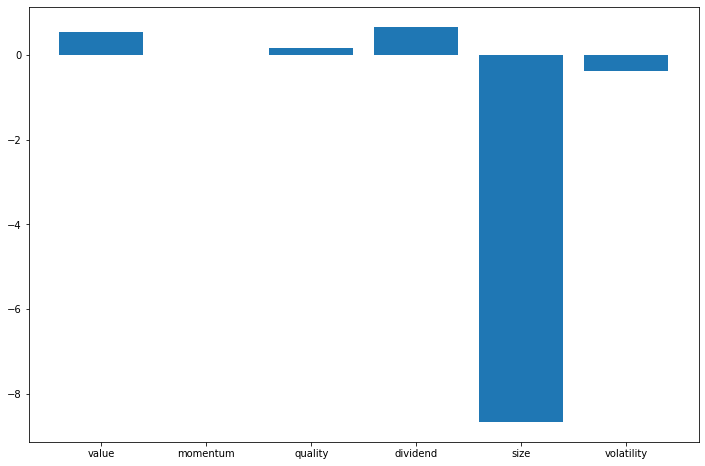

In [175]:
fig, ax1=plt.subplots(figsize=(12, 8))
ax1.bar(factor_score_diff.T.index.tolist(), factor_score_diff.values.tolist()[0])

In [144]:
# plt.bar(factor_res.T.index.values, factor_res.T)
# ax1.legend(labels = factor_res.columns,
#       fontsize = 12,
#       title = "factors",
#       title_fontsize = 18)
# ax1.legend_.set_bbox_to_anchor([1, 1])

In [ ]:
factor_res[col].iloc[-12]

In [ ]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.bar(factor_res.iloc[-1].sort_values().index, factor_res.iloc[-1].sort_values(), .5)

ax1.legend(labels = factor_res.columns,
      fontsize = 12,
      title = "factors",
      title_fontsize = 18)
ax1.legend_.set_bbox_to_anchor([1, 1])
    

In [ ]:
factor_res.columns

In [ ]:
idxw.sum(1)

In [ ]:
factor_score_res=pd.concat(factor_score_ls, axis=1)
factor_score_res.columns=factor_name_ls

In [ ]:
factor_score_res.mean()

In [ ]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.boxplot(factor_score_res, labels=factor_score_res.columns)

plt.xlabel('factors')
plt.ylabel('scores')
plt.title('factor score box plot')
plt.show()

In [ ]:
port_w

In [ ]:
factor_score_res.mean()

In [ ]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.boxplot(factor_score_res, labels=factor_score_res.columns)

plt.xlabel('factors')
plt.ylabel('scores')
plt.title('factor score box plot')
plt.show()